In [1]:
import numpy as np
import scipy as sp
import ot

from numpy import linalg as LA
import scipy
from scipy import signal
from scipy.fftpack import fft, fftshift
from scipy.sparse import csr_matrix
import networkx as nx

from IPython import display
import time

import sklearn
from sklearn import datasets
from numpy import matlib
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(1)

import seaborn as sns
sns.set_style("whitegrid")

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### MNIST data

In [2]:
#get MNIST dataset
from keras.datasets import mnist
import tensorflow as tf
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
#join train set and test set
data = np.vstack((x_train,x_test))
y = np.hstack((y_train, y_test))
print('data shape is', data.shape)

# Reshaping 
img_size = data.shape[1]
data = data.reshape(data.shape[0], img_size**2)
# Making sure that the values are float so that we can get decimal points after division
data = data.astype('float')


# Normalizing the RGB codes by dividing it to the max RGB value.
for i in range(data.shape[0]):
    data[i] +=0.00001
    data[i] = data[i] / np.sum(data[i])
print('data.shape is:', data.shape)

Using TensorFlow backend.


data shape is (70000, 28, 28)
data.shape is: (70000, 784)


### Choose a digit 

the number of digit 5 in the datatset is 6313


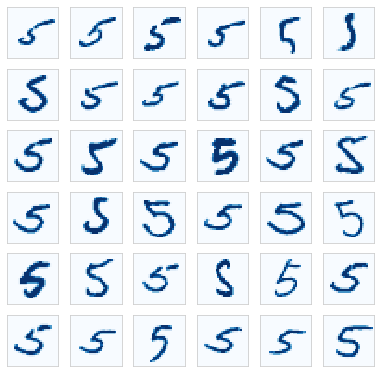

In [3]:
#Create data set for one digit
digit =5
data5 = data[y==digit]
Data5 = data5.reshape(data5.shape[0],img_size,img_size)
print('the number of digit',digit, 'in the datatset is', data5.shape[0])

n_row=6
n_col=6
plt.figure(figsize=(1.1 * n_col, 1.1 * n_row))
for i in range(1, n_row * n_col+1):
    plt.subplot(n_row, n_col, i)
    plt.imshow(Data5[i], cmap='Blues')
    plt.xticks(())
    plt.yticks(())

### Choose a cost matrix 

In [4]:
#cost matrix

C = np.zeros((data.shape[1],data.shape[1]))
N = 28
for i in range(data.shape[1]):
    for j in range(data.shape[1]):
        xi = i % N
        yi = i // N
        xj = j % N
        yj = j // N
        C[i,j] = (xi-xj)**2 + (yi-yj)**2
C /= C.max()

### Fonts Dataset

failed: .DS_Store


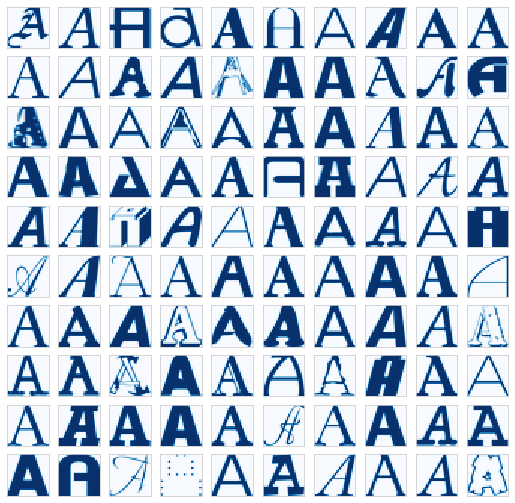

In [5]:
import os
import matplotlib.image as mpimg


# Normalizing the RGB codes by dividing it to the max RGB value.
def image_normalize(img) :
    img +=0.00001
    img = img / np.sum(img)
    return img
dataA = []
for path in os.listdir(os.path.join('./notMNIST_small/A')):
        path_letter = os.path.join('./notMNIST_small/A', path)
        try:
            img=mpimg.imread(path_letter) 
            img_n = image_normalize(img) 
            dataA.append(img_n)
        except:
            print("failed:", path)
        
        
Adata = np.array(dataA)
AAdata = Adata.reshape(Adata.shape[0], Adata.shape[1]*Adata.shape[1])

n_row=10
n_col=10
plt.figure(figsize=(0.9 * n_col, 0.9 * n_row))
for i in range(1, n_row * n_col+1):
    plt.subplot(n_row, n_col, i)
    plt.imshow(Adata[i], cmap='Blues')
    plt.xticks(())
    plt.yticks(())

## Gaussians


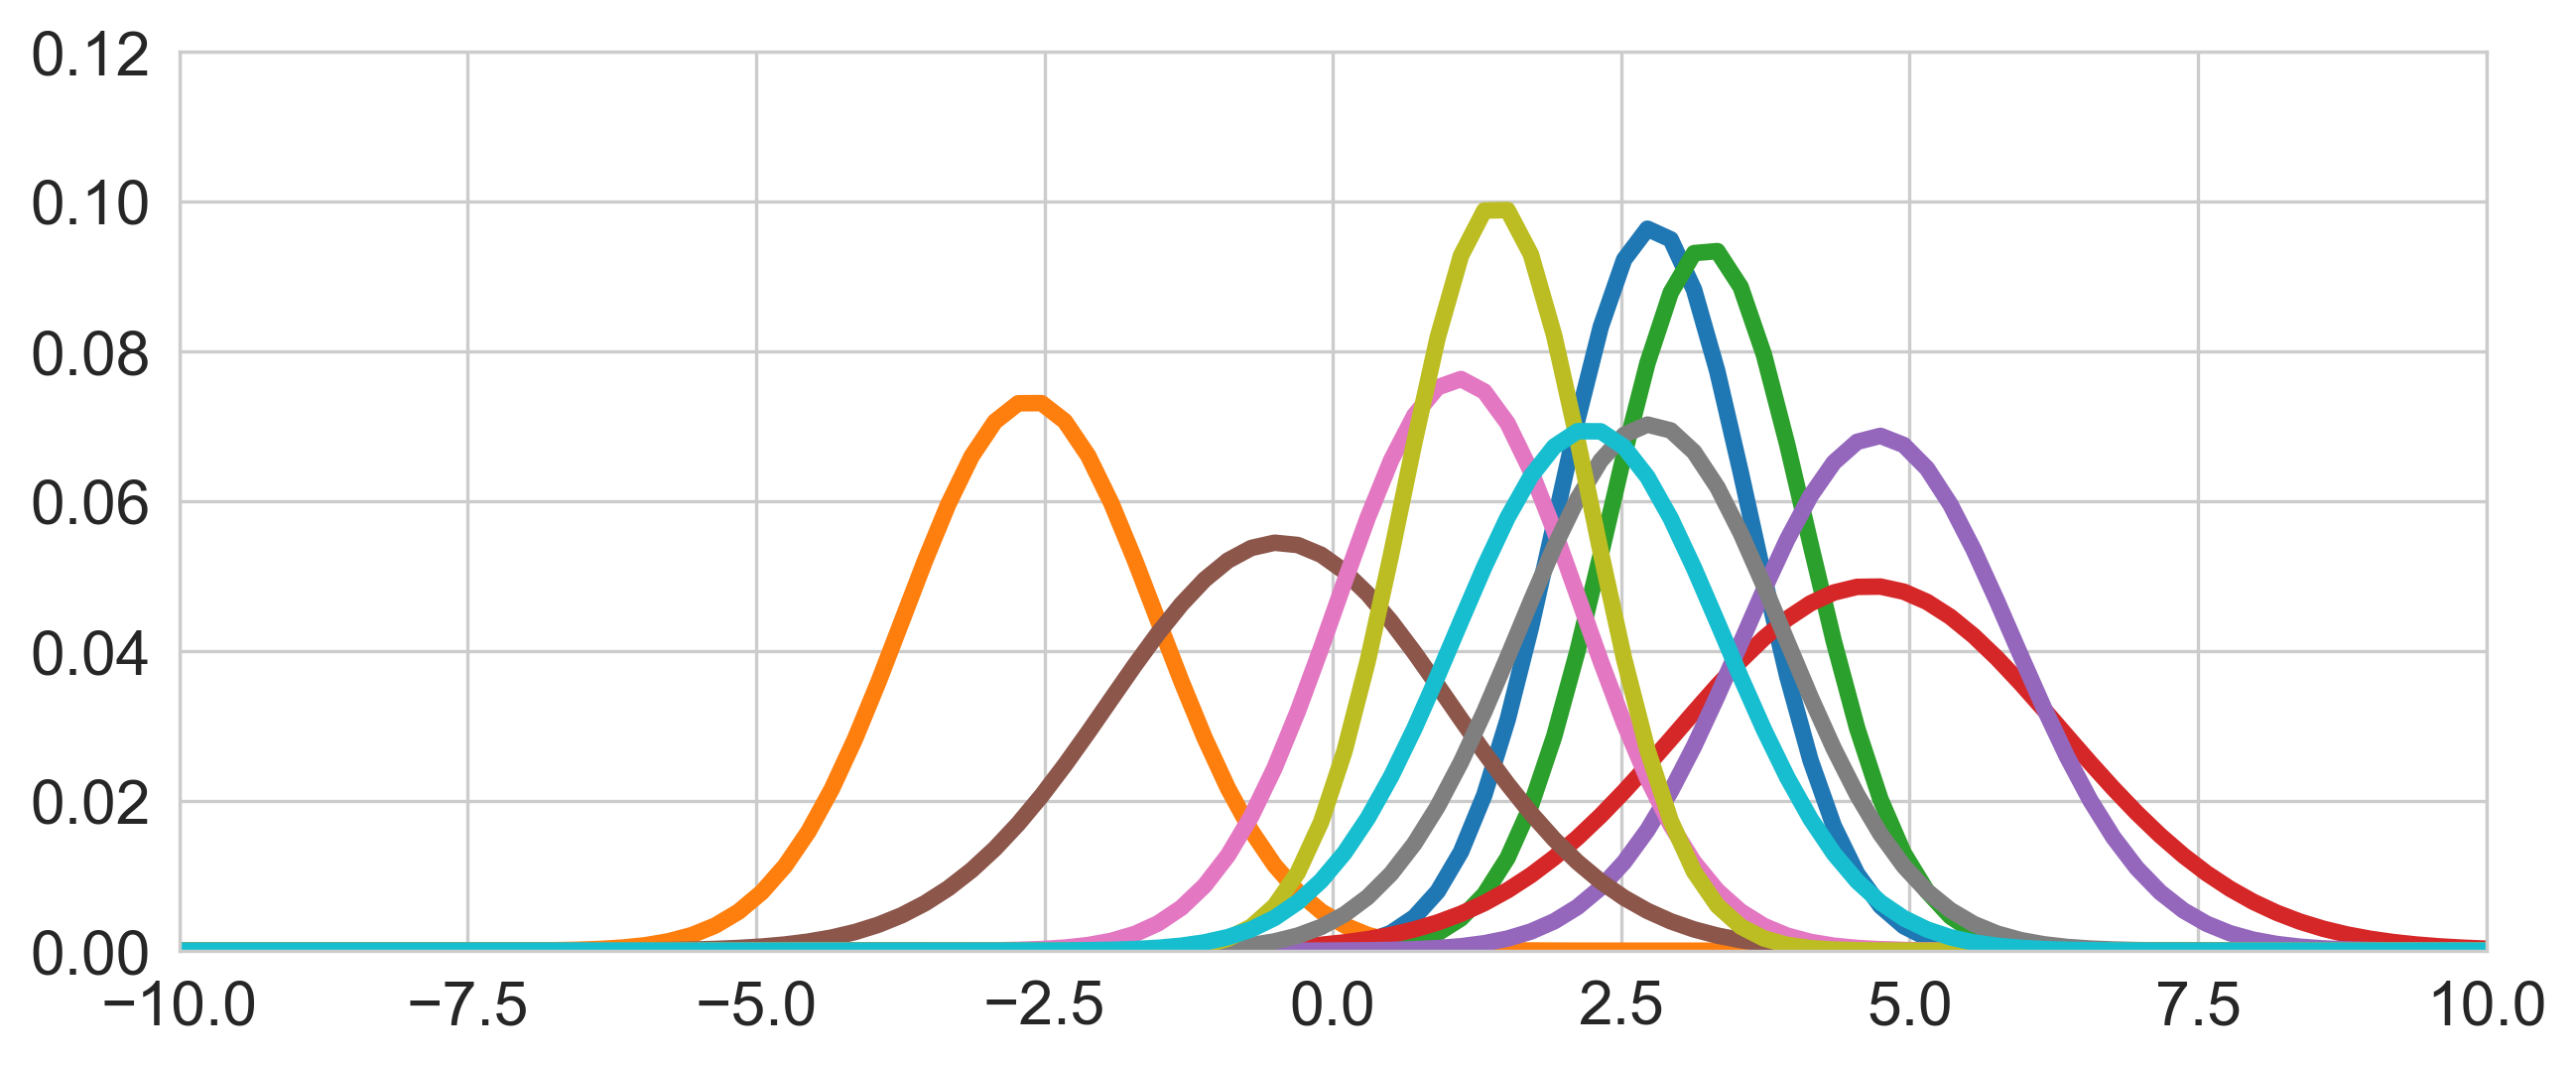

In [9]:
#Define the histogram $a,b$ as translated Gaussians.
Gaussian = lambda mu0,sigma0, z: 1/(sigma0 * np.sqrt(2 * np.pi)) * np.exp(-(z-mu0)**2/(2*sigma0**2))
def normalize(p):
   # p += 0.00001
    p =  p/np.sum(p)
    return p

n=100
z =  np.linspace(-10, 10, n)
K = 10


plt.figure(figsize = (10,4), dpi=300)
plt.ylim(0, 0.12)
plt.xlim(-10, 10)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)


gaus = np.zeros((K,z.shape[0]))

np.random.seed(13) 
mu = np.random.uniform(-5,5,K)
sigma = np.random.uniform(0.8, 1.8, K)

for i in range(K):
    gaus[i] = Gaussian(mu[i],sigma[i], z)
    gaus[i] = normalize(gaus[i])
    plt.plot(z, gaus[i], linewidth=4)

M = ot.utils.dist0(n)
M /= M.max()

In [7]:
# IBP barycenter
M = ot.utils.dist0(n)
M /= M.max()

regIBP = 0.0005
bary_wass = ot.bregman.barycenter(gaus.T, M, reg=regIBP)



##### The true Gaussian Barycenter

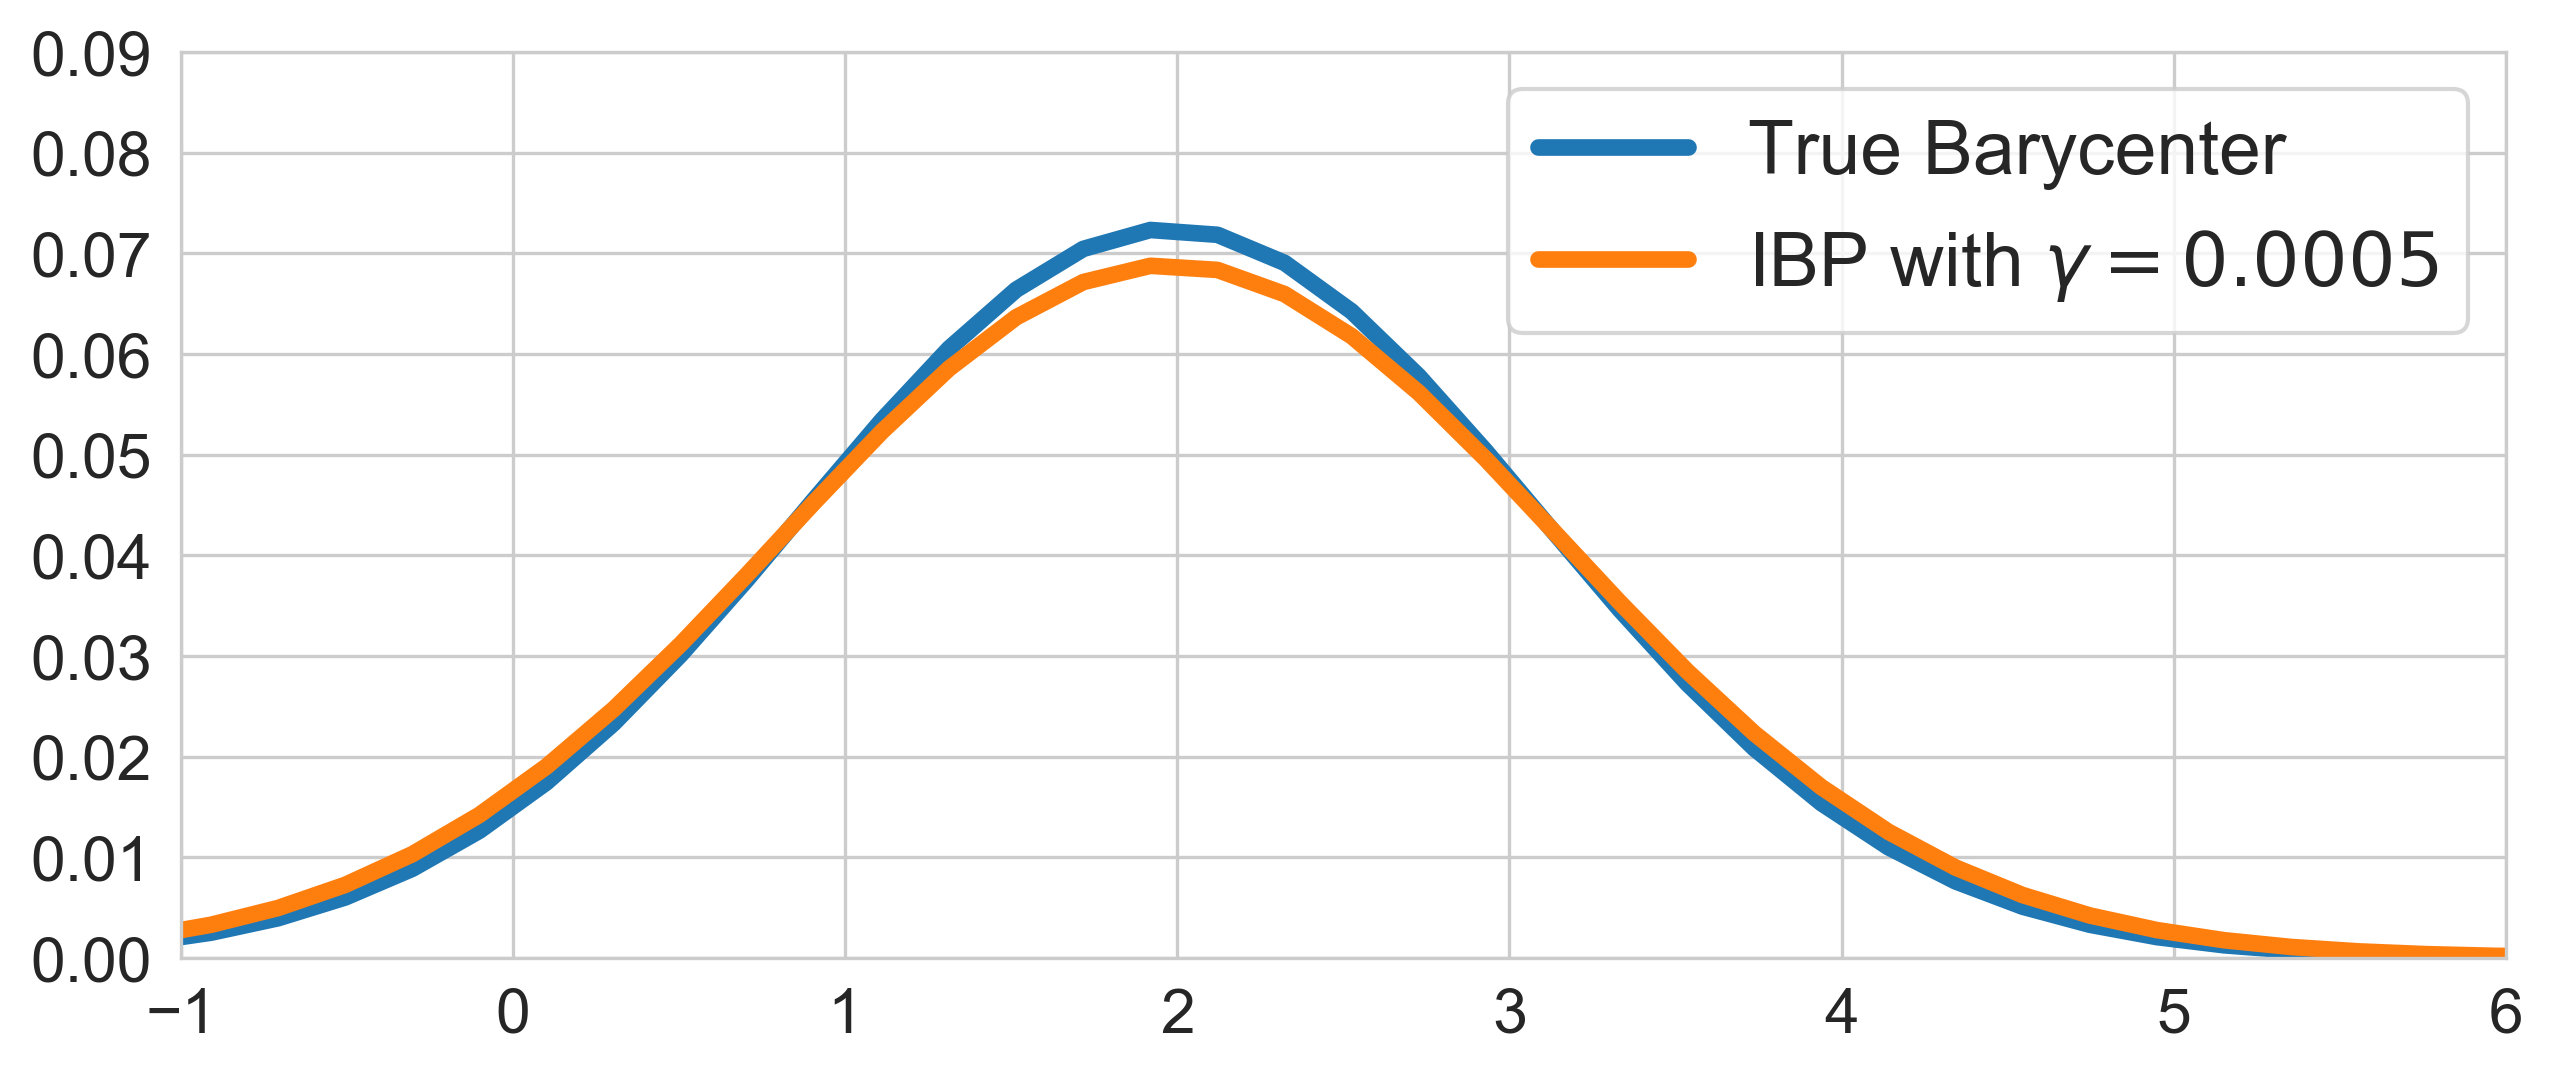

In [8]:
#true mean
barmu = np.sum(mu)/len(mu)

#true variance
barsigma = np.sum(sigma)/len(sigma)


#True barycenter
bartrue = normalize(Gaussian(barmu,barsigma,z))

plt.figure(figsize = (10,4), dpi=300)
plt.ylim(0, 0.09)
plt.xlim(-1, 6)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.plot(z, bartrue, linewidth=4, label='True Barycenter')
plt.plot(z, bary_wass, linewidth=4, label='IBP with $\gamma =%.3g$'%regIBP)

plt.legend(loc="upper right", prop={'size': 18}, frameon=True)
plt.show()

# Area-convex regularization for Dual Extrapolation

In [62]:
class WassersteinBarycenterSolver:
    def __init__(self, n, m, d, q,  bartrue, alpha=1/3, beta=1/6, e_coeff=5):
        self.n = n
        self.m = m
        self.alpha = alpha # theoretically : 1 / kappa
        self.beta  = beta  # theoretically : 1 / (2 * kappa)
        self.e_coeff = e_coeff # theoretically : 5
        self.d = d
        self.dnorm = LA.norm(d, np.inf)
        self.q = q
        self.eps = 1e-5
    
    def multA(self, x):
        n = self.n
        temp = x.reshape(n,n)
        out = np.concatenate((np.sum(temp,axis=1), np.sum(temp,axis=0)), axis=0)
        return out
    
    def multAt(self, y):
        n = self.n
        out = np.repeat(y[:n],n) + np.tile(y[n:],n)
        return out
    
    def G_x(self, x,p,y):
        n = self.n
        m = self.m
        dnorm = self.dnorm
        result = np.zeros((m, n**2))
        for i in range(m):
            result[i] = self.d + 2 * dnorm * self.multAt(y[i])
        return result / m
    
    def G_p(self, x,p,y):
        n = self.n
        m = self.m
        dnorm = self.dnorm
        return - 2 * dnorm / m * np.sum(y[:,:n], axis=0)
    
    def G_y(self, x,p,y):
        n = self.n
        m = self.m
        dnorm = self.dnorm
        
        result = np.zeros((m, 2*n))
        for i in range(m):
            Ax_i = self.multA(x[i])
            result[i, :n] = p - Ax_i[:n]
            result[i, n:] = self.q[i] - Ax_i[n:]
        return 2. * dnorm / m * result
    
    def alternating_minimization(self, v, v_mp1,  u, iters=25):
        # Solve minimization problem of type 
        # min H(x,y) = <v,x> + <u, y> + r(x,y)
        n = self.n
        m = self.m
        dnorm = self.dnorm
        e_coeff = self.e_coeff
        
        x = 1/n**2 * np.ones((m, n**2))
        p = 1/n * np.ones(n)
        y = np.zeros((m, 2*n))
        out_x = x.copy()
        out_p = p.copy()
        out_y = y.copy()
        
        for t in range(iters):
            for i in range(m):
                gamma = 1/(2*e_coeff) * (m / (2 * dnorm) * v[i] + self.multAt(y[i]**2))
                softx = sp.special.softmax(-gamma)
                x[i] = softx /np.sum(softx )
            gamma = 1/e_coeff * (1 / (2 * dnorm) * v_mp1 + 1/m * np.sum(y[:,:n], axis=0)) 
            softp = sp.special.softmax(-gamma)
            p = softp/np.sum(softp)
            for i in range(m):
                Ax_i = self.multA(x[i])
                y[i,:n] = -m/(4 * dnorm) * u[i,:n] / (Ax_i[:n] + p + 1e-9)
                y[i,n:] = -m/(4 * dnorm) * u[i,n:] / (Ax_i[n:] + 1e-9)
                mask = np.abs(y[i]) > 1
                y[i, mask] /= np.abs(y[i, mask])
                
            if (np.linalg.norm(out_x - x, ord=1) + np.linalg.norm(out_p - p, ord=1) < self.eps) and (np.linalg.norm(out_y - y, ord=np.infty) < self.eps):
                return x, p, y

            out_x = x
            out_p = p
            out_y = y

        print('AM Failed')
        return out_x, out_p,out_y
        
            
        
    def solve_display(self, iters=10000, verbose=False):
        start_time = time.time()
        n = self.n
        m = self.m
        dnorm = self.dnorm
        alpha = self.alpha
        beta = self.beta
        e_coeff = self.e_coeff
        
        loss_history=[]
        time_history=[]
        p_history=[]
        
        Wass = 0
        for i in range(gaus.shape[0]): 
            Wass += ot.emd2(bartrue, gaus[i], M) # exact linear program
              
        Wass = Wass/gaus.shape[0]
       
        
        s_x = np.zeros((m, n**2))
        s_p = np.zeros(n)
        s_y = np.zeros((m, 2*n))
        
        out_x = s_x.copy()
        out_p = s_p.copy()
        out_y = s_y.copy()
        
        r_grad_x = 4 * e_coeff * dnorm / m * (2*np.log(n) + 1) * np.ones((m, n**2))
        r_grad_p = 2 * e_coeff * dnorm * (np.log(n) + 1) * np.ones(n)
        r_grad_y = np.zeros((m, 2*n))
        
        for k in range(iters):
            v =     s_x - r_grad_x
            v_mp1 = s_p - r_grad_p
            u =     s_y - r_grad_y
    
            z_x, z_p, z_y = self.alternating_minimization(v, v_mp1, u)
            
            v     += alpha * self.G_x(z_x, z_p, z_y)
            v_mp1 += alpha * self.G_p(z_x, z_p, z_y)
            u     += alpha * self.G_y(z_x, z_p, z_y)
            
            w_x, w_p, w_y = self.alternating_minimization(v, v_mp1, u)
            s_x += beta * self.G_x(w_x, w_p, w_y)
            s_p += beta * self.G_p(w_x, w_p, w_y)
            s_y += beta * self.G_y(w_x, w_p, w_y)
        
            out_x = k/(k+1) * out_x + 1/(k+1) * w_x
            out_p = k/(k+1) * out_p + 1/(k+1) * w_p
            out_y = k/(k+1) * out_y + 1/(k+1) * w_y
            
            
            #Output
            
            Wass_c = 0
            for i in range(gaus.shape[0]): 
                Wass_c += ot.emd2(out_p,gaus[i], M)
            Wass_c = Wass_c/gaus.shape[0]
            loss =  Wass_c - Wass
            
 
            mytime = time.time() - start_time
            loss_history.append(loss)
            time_history.append(mytime)
            p_history.append(out_p)
            
            if verbose and k % 100 == 0:
                    # Visualize
                display.clear_output(wait=True)
                plt.figure(figsize = (10,4), dpi=300)
                plt.plot(np.linspace(-10, 10, n), out_p, linewidth=4)
                plt.show()

                print('Pass {} iterations'.format(k), flush=True)   
                with open('WBimages/DualExtr/p_his/p_his.npy', 'wb') as f:
                    np.save(f, p_history)  
                with open('WBimages/DualExtr/loss_his/loss_his.npy', 'wb') as f:
                    np.save(f, loss_history)
                with open('WBimages/DualExtr/time_his/time_his.npy', 'wb') as f:
                    np.save(f, time_history) 
                    

        return time_history, p_history,  loss_history


    def solve_font(self, iters=10000, verbose=False):
        n = self.n
        m = self.m
        dnorm = self.dnorm
        alpha = self.alpha
        beta = self.beta
        e_coeff = self.e_coeff
        
        
        s_x = np.zeros((m, n**2))
        s_p = np.zeros(n)
        s_y = np.zeros((m, 2*n))
        
        out_x = s_x.copy()
        out_p = s_p.copy()
        out_y = s_y.copy()
        
        r_grad_x = 4 * e_coeff * dnorm / m * (2*np.log(n) + 1) * np.ones((m, n**2))
        r_grad_p = 2 * e_coeff * dnorm * (np.log(n) + 1) * np.ones(n)
        r_grad_y = np.zeros((m, 2*n))
        
        for k in range(iters):
            v =     s_x - r_grad_x
            v_mp1 = s_p - r_grad_p
            u =     s_y - r_grad_y
    
            z_x, z_p, z_y = self.alternating_minimization(v, v_mp1, u)
            
            v     += alpha * self.G_x(z_x, z_p, z_y)
            v_mp1 += alpha * self.G_p(z_x, z_p, z_y)
            u     += alpha * self.G_y(z_x, z_p, z_y)
            
            w_x, w_p, w_y = self.alternating_minimization(v, v_mp1, u)
            s_x += beta * self.G_x(w_x, w_p, w_y)
            s_p += beta * self.G_p(w_x, w_p, w_y)
            s_y += beta * self.G_y(w_x, w_p, w_y)
        
            out_x = k/(k+1) * out_x + 1/(k+1) * w_x
            out_p = k/(k+1) * out_p + 1/(k+1) * w_p
            out_y = k/(k+1) * out_y + 1/(k+1) * w_y
            

            if verbose and k % 100 == 0:
                    # Visualize
                display.clear_output(wait=True)
                plt.imshow(out_p.reshape(28,28), cmap='Blues') 
                plt.xticks(())
                plt.yticks(())
                plt.show()

                print('Pass {} iterations'.format(k), flush=True)
                with open('WBimages/DualExtr/out_p/out_p.npy', 'wb') as f:
                    np.save(f, out_p)  

                    

        return out_p


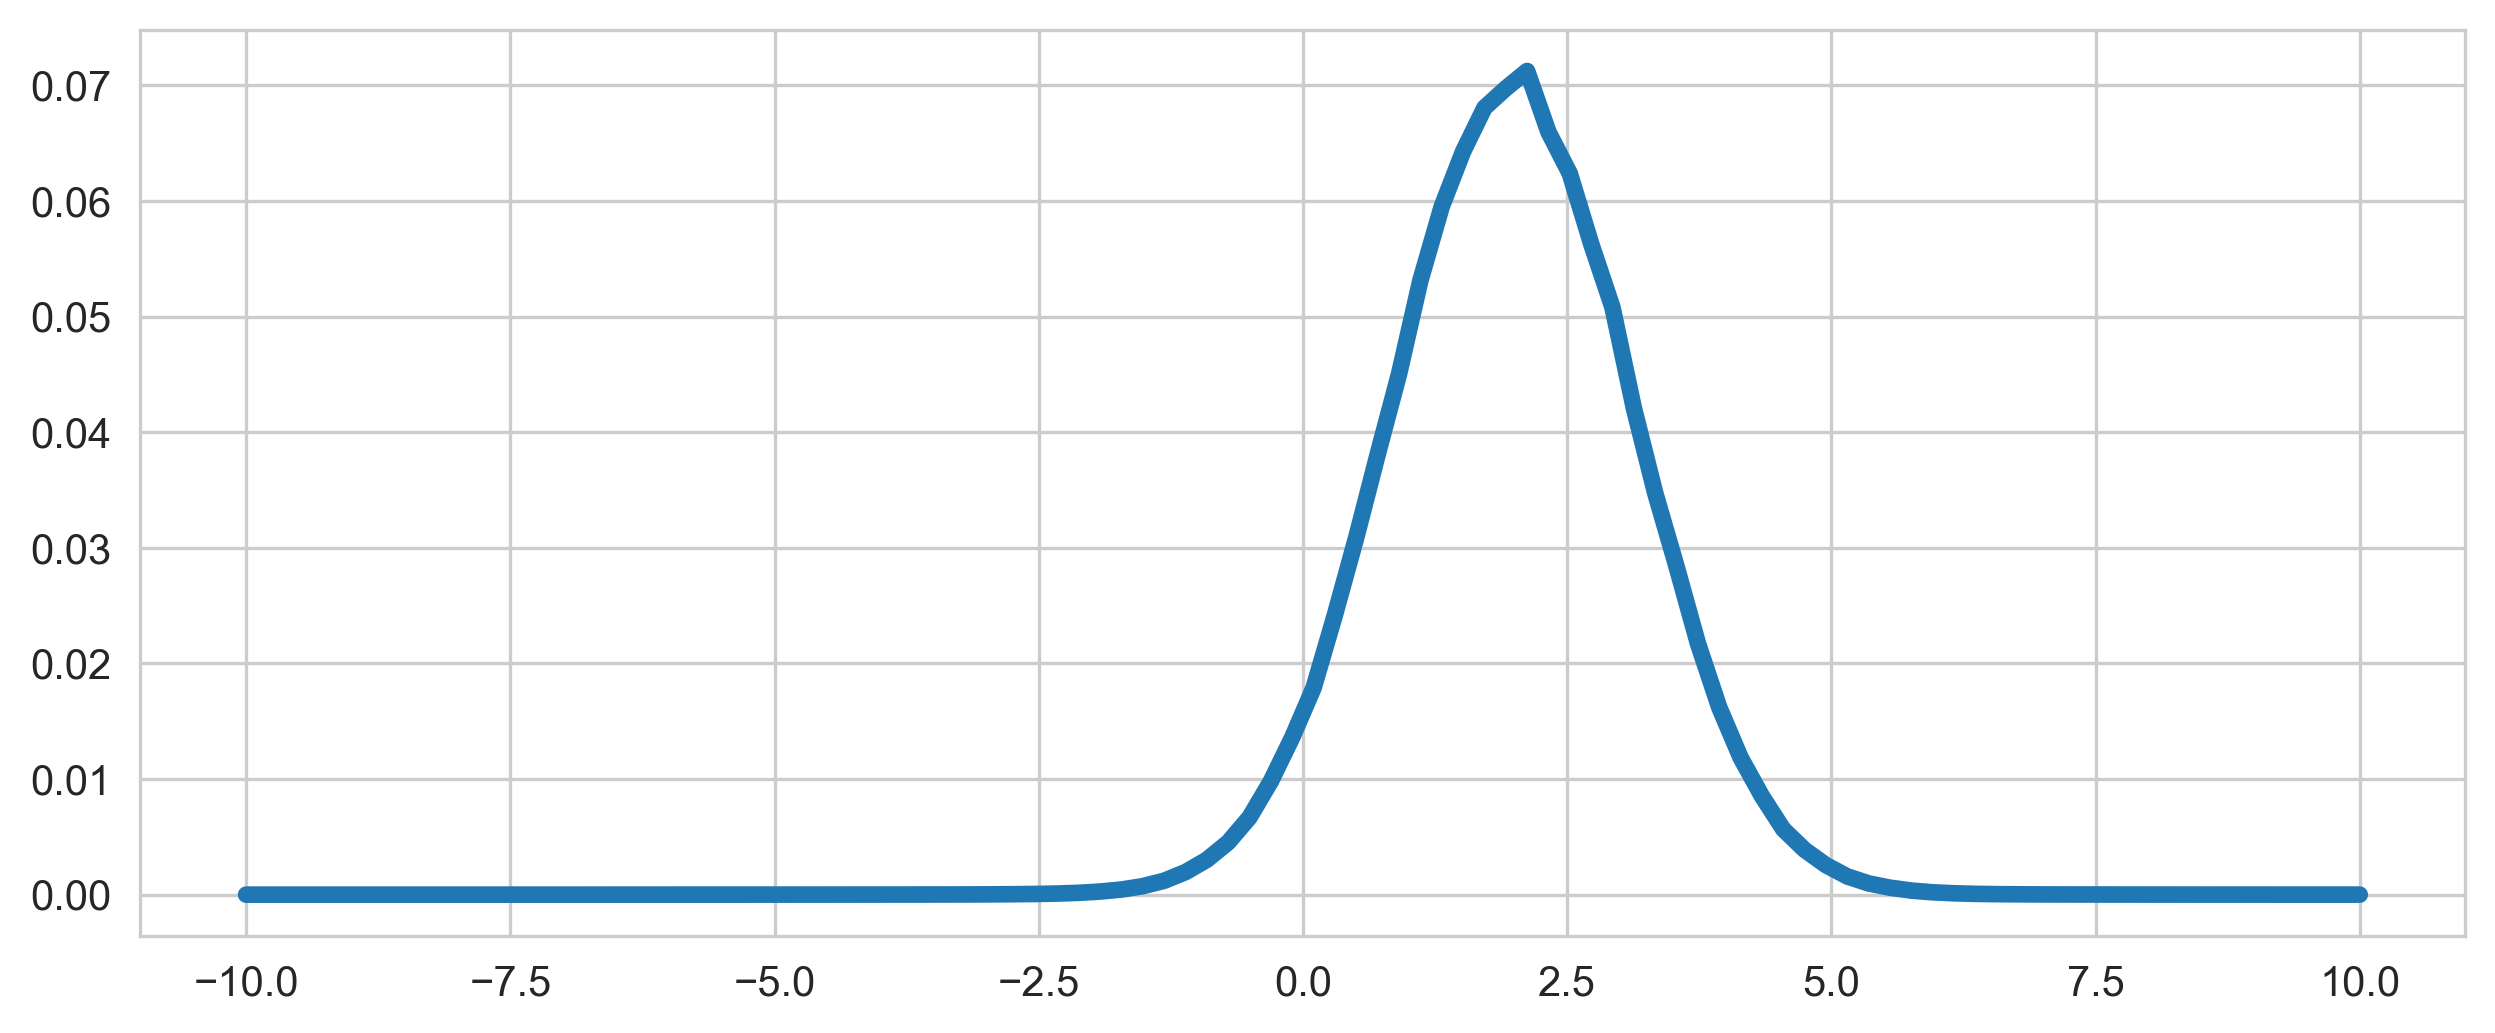

Pass 276600 iterations


KeyboardInterrupt: 

In [634]:
solver = WassersteinBarycenterSolver(n, K, M.flatten(),gaus,bartrue, 2*K/3, 2*K/(2*3), 5)
time_history, p_history,  loss_history = solver.solve_display(10000000, verbose=True)

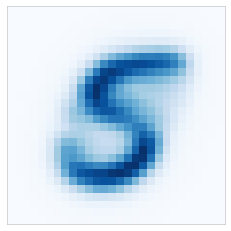

Pass 4600 iterations


KeyboardInterrupt: 

In [643]:
#MNIST
K=50
solver = WassersteinBarycenterSolver(784, K, C.flatten(), data5[:K], bartrue, K/3, K/(2*3), 5)
p_hat = solver.solve_font(1000000, verbose=True)

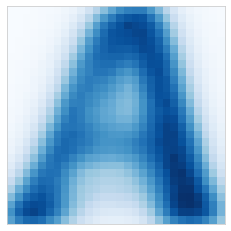

Pass 2000 iterations


KeyboardInterrupt: 

In [25]:
#FONTS
K=50
solver = WassersteinBarycenterSolver(784, 100, C.flatten(), AAdata[:100], bartrue, K/3, K/(2*3), 5)
p_hat = solver.solve_font(1000000, verbose=True)

# Mirror Prox Algorithm

In [10]:
def mirror(data,  C,  numItermax=100000, stopThr=1e-9):
    
    
    d= C.flatten()# vectorized cost matrix
    
    m = data.shape[0] # number of measures
    n = data.shape[1] # img_size**
    #define algorithm constants
    dnorm = LA.norm(d, np.inf)
    eta = 1/(4*dnorm*np.sqrt(6*n*np.log(n)))
    alpha = 2*dnorm*eta*n
    #Theoretical value of beta and gamma
#     beta =  6*dnorm*eta*np.log(n)
#     gamma=  3*eta*m*np.log(n)
    #Acceleration via step size
    beta =  6*dnorm*eta*np.log(n)/m
    gamma= 3*eta*np.log(n)

    #define inputs
    p = np.ones(n) / n
    s = np.copy(p)
    x = np.ones((m, n**2)) / (n**2)
    u = np.copy(x)
    y = np.zeros((m, 2*n))
    v = np.copy(y)
    shat = np.copy(p)
    
    
    #edge-incidence matrix

    A = np.zeros((2*n, n**2))
    i=0
    j=0
    for i in range(n):
        A[i, j:j+n]=1
        j+=n
    t=0
    for i in range(n,2*n):
        for j in range(t, n**2, n):
            A[i,j]=1
        t+=1

    A = csr_matrix(A)

    #Algorithm
    err = 1
    cpt=0
    while (err > stopThr and cpt < numItermax):
        cpt += 1
        
        for i in range (0,m):
            b = np.concatenate((p,data[i]),axis=0)
            v[i] = y[i] + alpha * (A.dot(x[i]) - b) # variable for y
           
            flag = np.abs(v[i]) >1
            v[i, flag] = np.sign(v[i, flag])
            
            sft = x[i]*np.exp(-gamma * (d + 2*dnorm * A.transpose().dot(y[i])))
            u[i] =  sft / np.sum( sft )  # variable for x
        
        sft2= p*np.exp(beta*np.sum(y[:,:n],0))
        s =  sft2/ np.sum( sft2 )  # variable for p
        pold = np.copy(shat)
        shat +=s       
        for i in range (0,m):
            b = np.concatenate((s,data[i]),axis=0)
            y[i] = y[i] + alpha * (A.dot(u[i]) - b) 

            flag = np.abs(y[i]) >1
            y[i, flag] = np.sign(y[i, flag])
            
            sft = x[i]*np.exp(-gamma * (d + 2*dnorm * A.transpose().dot(v[i])))
            x[i] =  sft/ np.sum( sft ) 
        
        sft2 = p*np.exp(beta*np.sum(v[:,:n],0)) 
        p = sft2 / np.sum( sft2 )  
        
        if cpt % 10 == 1:
            err = np.sum(np.abs(pold - shat/cpt))
            
        phat = shat / (cpt+1)

            
    
    #Output   

    return phat

In [11]:
def mirror_display(data,  bartrue, C,  numItermax=100000, stopThr=1e-9, verbose = True):
    start_time = time.time()
    
    d= C.flatten()# vectorized cost matrix
    
    m = data.shape[0] # number of measures
    n = data.shape[1] # img_size**
    #define algorithm constants
    dnorm = LA.norm(d, np.inf)
    eta = 1/(4*dnorm*np.sqrt(6*n*np.log(n)))
    alpha = 2*dnorm*eta*n
#     beta =  6*dnorm*eta*np.log(n)
#     gamma=  3*eta*m*np.log(n)
    beta =  6*dnorm*eta*np.log(n)/m
    gamma= 3*eta*np.log(n)

    #define inputs
    p = np.ones(n) / n
    s = np.copy(p)
    x = np.ones((m, n**2)) / (n**2)
    u = np.copy(x)
    y = np.zeros((m, 2*n))
    v = np.copy(y)
    shat = np.copy(p)
    
    loss_history=[]
    time_history=[]
    p_history=[]
        
    Wass = 0
    for i in range(gaus.shape[0]): 
        Wass += ot.emd2(bartrue, gaus[i], M) # exact linear program
              
    Wass = Wass/gaus.shape[0]
    
    #edge-incidence matrix

    A = np.zeros((2*n, n**2))
    i=0
    j=0
    for i in range(n):
        A[i, j:j+n]=1
        j+=n
    t=0
    for i in range(n,2*n):
        for j in range(t, n**2, n):
            A[i,j]=1
        t+=1

    A = csr_matrix(A)

    #Algorithm
    err = 1
    cpt=0
    while (err > stopThr and cpt < numItermax):
        cpt += 1
        
    #for k in range(0, numItermax):

        for i in range (0,m):
            b = np.concatenate((p,data[i]),axis=0)
            v[i] = y[i] + alpha * (A.dot(x[i]) - b) # variable for y
           
            flag = np.abs(v[i]) >1
            v[i, flag] = np.sign(v[i, flag])
            
            sft = x[i]*np.exp(-gamma * (d + 2*dnorm * A.transpose().dot(y[i])))
            u[i] =  sft / np.sum( sft )  # variable for x
        
        sft2= p*np.exp(beta*np.sum(y[:,:n],0))
        s =  sft2/ np.sum( sft2 )  # variable for p
        pold = np.copy(shat)
        shat +=s       
        for i in range (0,m):
            b = np.concatenate((s,data[i]),axis=0)
            y[i] = y[i] + alpha * (A.dot(u[i]) - b) 

            flag = np.abs(y[i]) >1
            y[i, flag] = np.sign(y[i, flag])
            
            sft = x[i]*np.exp(-gamma * (d + 2*dnorm * A.transpose().dot(v[i])))
            x[i] =  sft/ np.sum( sft ) 
        
        sft2 = p*np.exp(beta*np.sum(v[:,:n],0)) 
        p = sft2 / np.sum( sft2 )  
        
        if cpt % 10 == 1:
            err = np.sum(np.abs(pold - shat/cpt))
            
        phat = shat / (cpt+1)
        p_history.append(phat)
        
        Wass_c = 0
        for i in range(gaus.shape[0]): 
            Wass_c += ot.emd2(phat,gaus[i], M)
        Wass_c = Wass_c/gaus.shape[0]
        loss =  Wass_c - Wass
            
        loss_history.append(loss)
    
#             # Visualize
#             display.clear_output(wait=True)
#             plt.figure(figsize=(6, 4), dpi=300)
#             plt.xlabel("$\ln$(working time)")
#             plt.ylabel("$\ln$(loss in function value)")
#             plt.plot(np.log(time_history), np.log(loss_history), 'b', c = 'b')
#             plt.show()
#             print('Current loss: %f' % loss) 

            
        mytime = time.time() - start_time
        time_history.append(mytime)
       
            
        if verbose and cpt % 100 == 0:
                    # Visualize
                display.clear_output(wait=True)
                plt.figure(figsize = (10,4), dpi=300)
                plt.plot(np.linspace(-10, 10, n), phat, linewidth=4)
                plt.show()

                print('Pass {} iterations'.format(cpt), flush=True)
                print(mytime)
#                 with open('WBimages/DualExtr/iter{}.npy'.format(k), 'wb') as f:
#                     np.save(f, p_history)  
#                 with open('WBimages/loss/iter{}.npy'.format(k), 'wb') as f:
#                     np.save(f, loss_history)
#                 with open('WBimages/time/iter{}.npy'.format(k), 'wb') as f:
#                     np.save(f, time_history)   
                with open('WBimages/Mirr/p_his/p_his.npy', 'wb') as f:
                    np.save(f, p_history)  
                with open('WBimages/Mirr/loss_his/loss_his.npy', 'wb') as f:
                    np.save(f, loss_history)
                with open('WBimages/Mirr/time_his/time_his.npy', 'wb') as f:
                    np.save(f, time_history) 
    #Output   

    return time_history, p_history,  loss_history

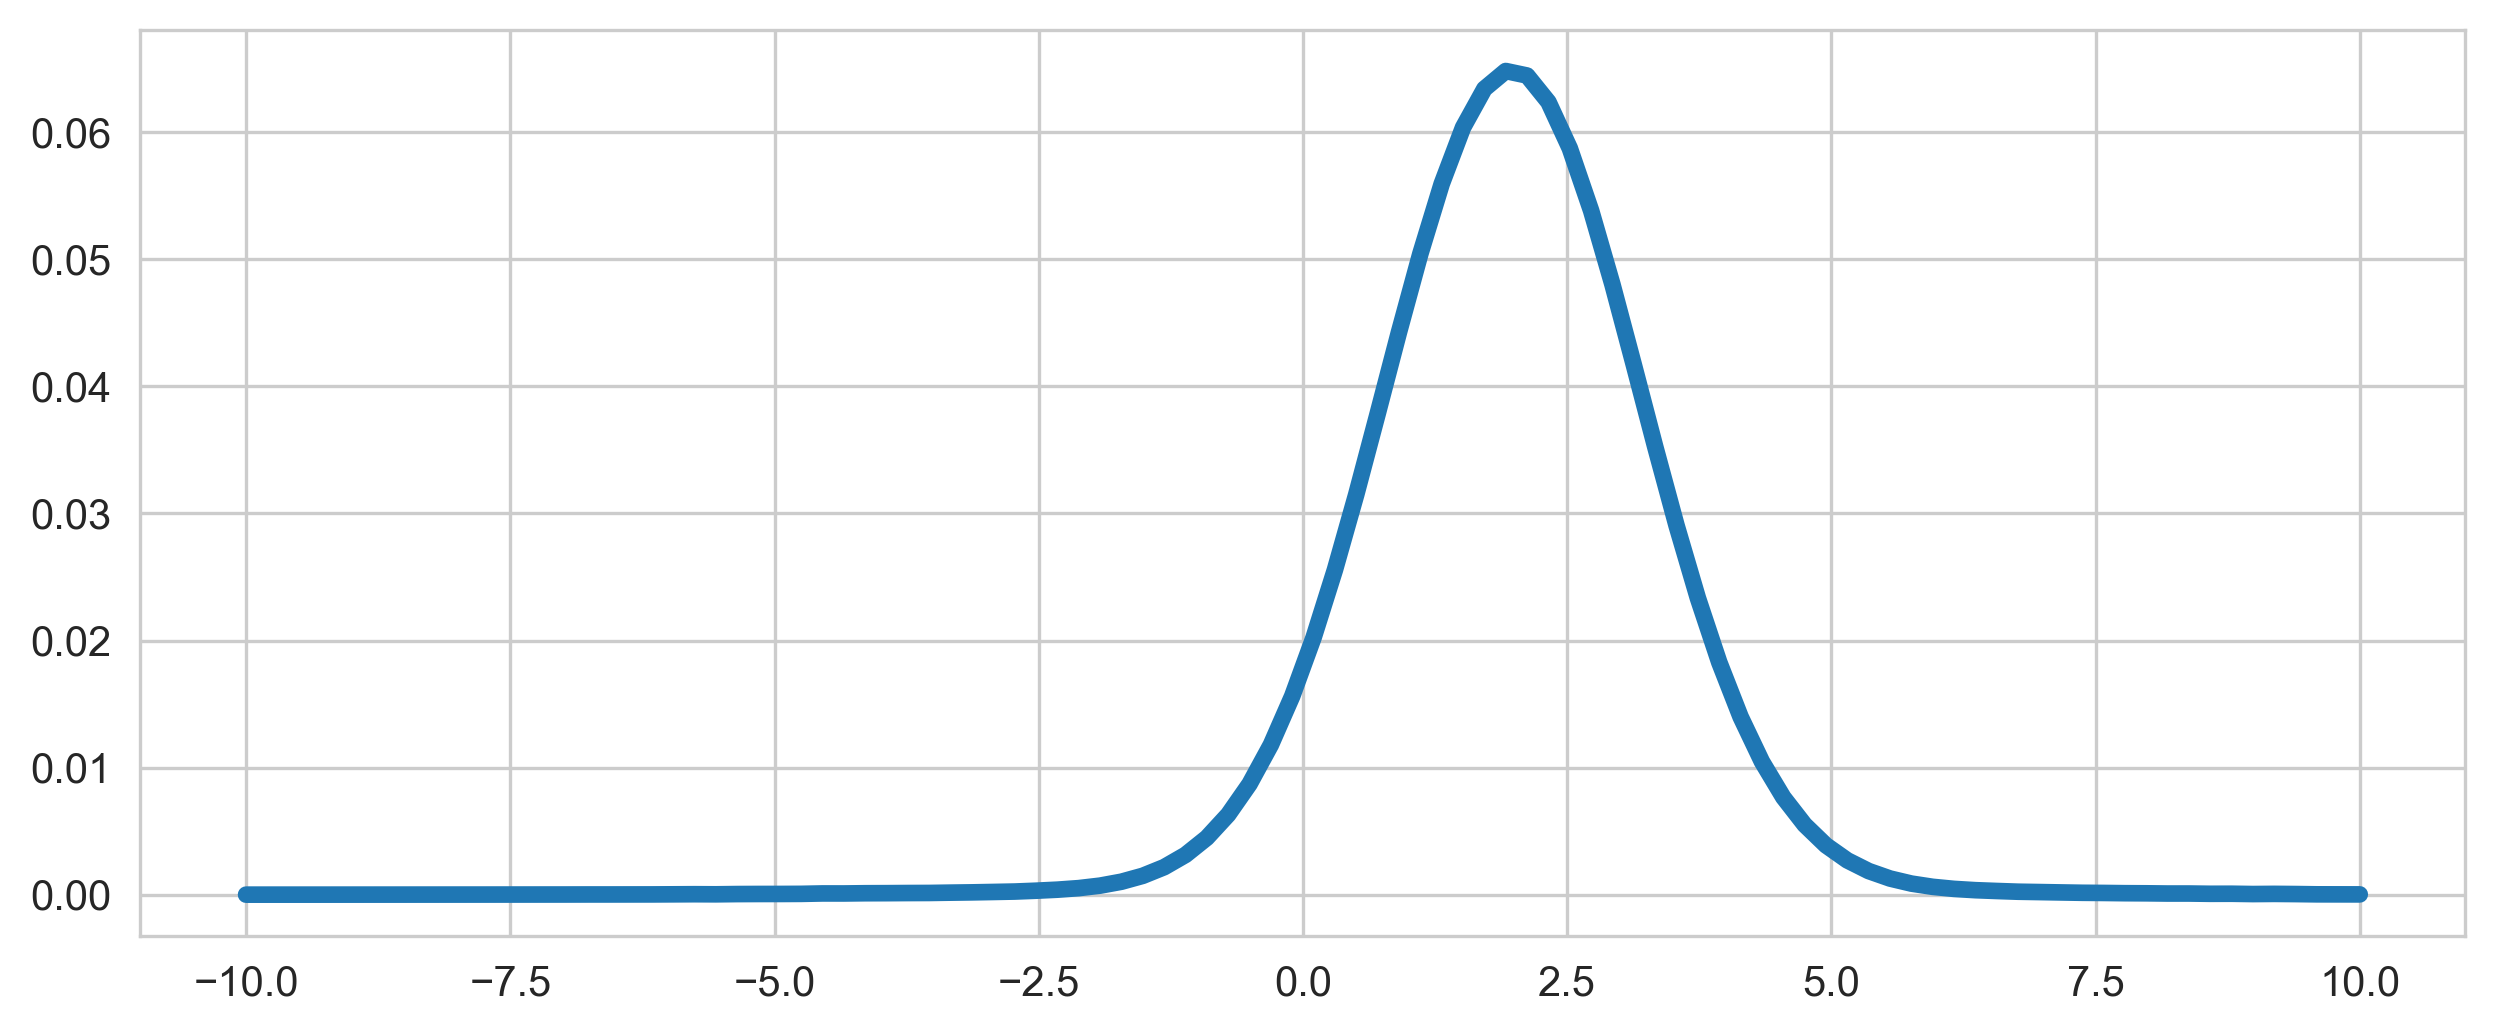

Pass 119900 iterations
4804.162099838257


In [ ]:
time_histor_mir, p_histor_mir,  loss_history_mir = mirror_display(gaus, bartrue, M, numItermax=1000000)


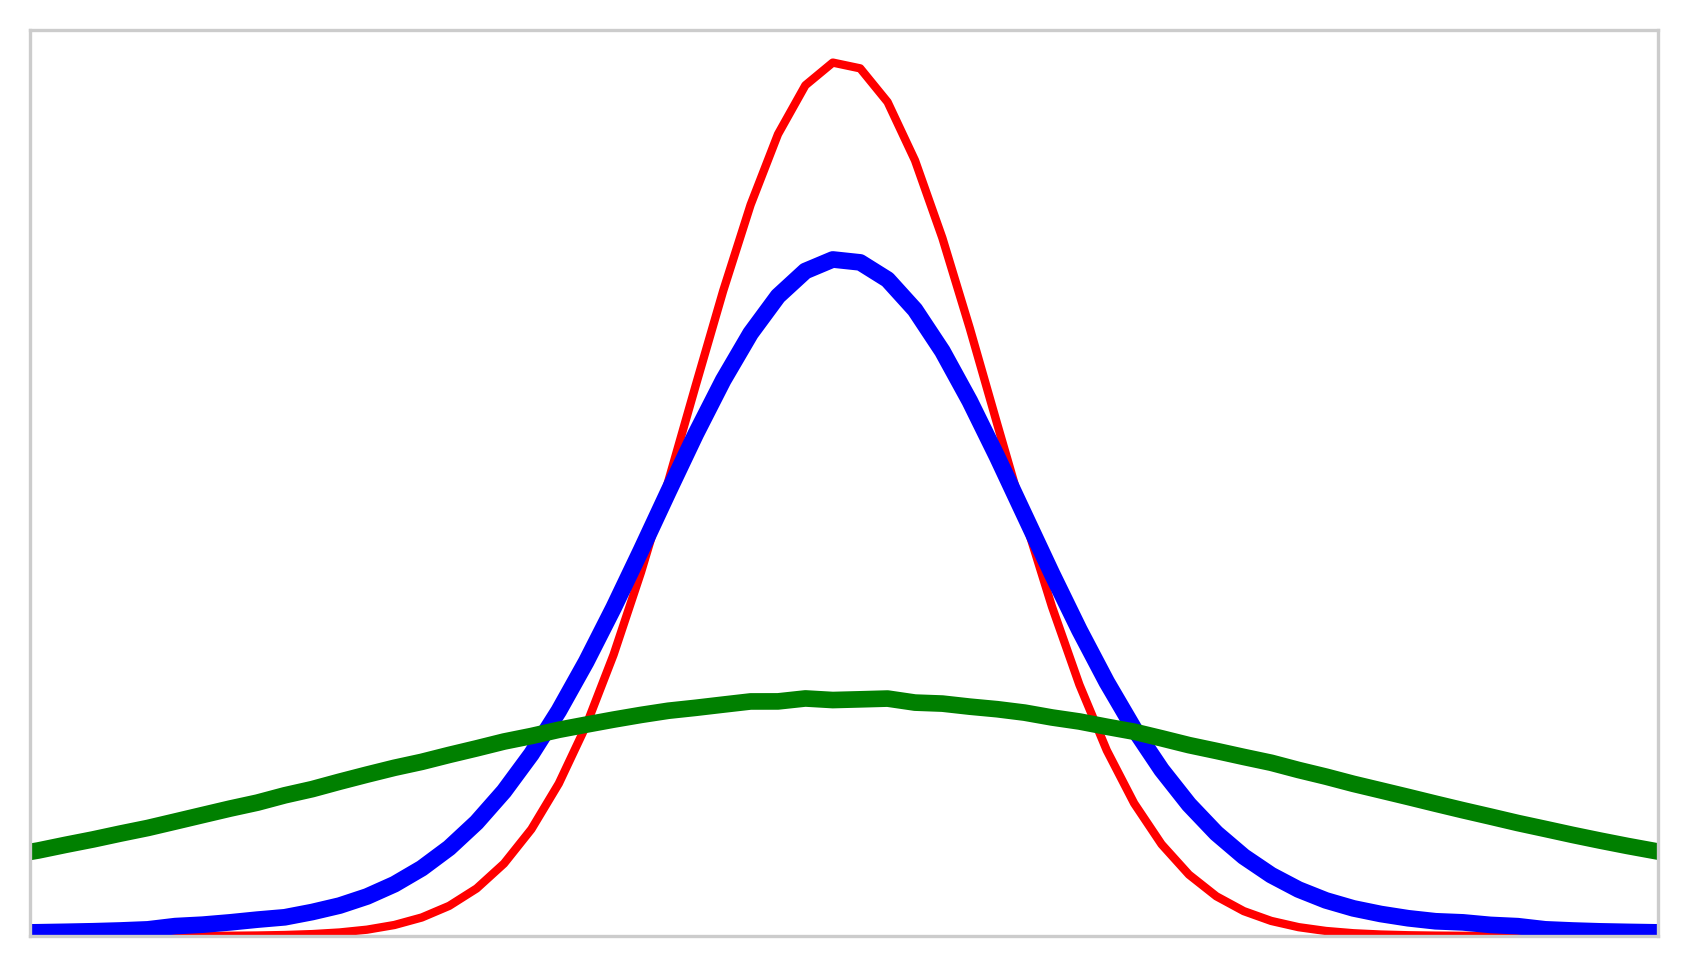

In [464]:
#AFter 20 seconds
plt.figure(figsize = (7,4), dpi=300)
plt.plot(np.linspace(-10, 10, n), bartrue, linewidth=2, c= 'r', label='True Barycenter')


plt.plot(np.linspace(-10, 10, n), p_history_mir[1050], linewidth=4, c = 'b',label='Mirror Prox for WB')
plt.plot(np.linspace(-10, 10, n), p_history[240], linewidth=4, c = 'g',label='Dual Extrapolation for WB')

# plt.plot(z, bary_wass, linewidth=2, label='IBP with $\gamma =%.3g$'%regIBP, c = 'orange')

plt.ylim(0, 0.075)
plt.xlim(-4, 8)
plt.xticks([])
plt.yticks([])
#plt.legend(loc="upper left", prop={'size': 10.5}, frameon=True)
plt.show()

In [465]:
#After 100 seconds
plt.figure(figsize = (7,4), dpi=300)
plt.plot(np.linspace(-10, 10, n), bartrue, linewidth=2, c= 'r', label='True Barycenter')


plt.plot(np.linspace(-10, 10, n), p_history_mir[4030], linewidth=4, c = 'b',label='Mirror Prox for WB')
plt.plot(np.linspace(-10, 10, n), p_history[1175], linewidth=4, c = 'g',label='Dual Extrapolation for WB')

# plt.plot(z, bary_wass, linewidth=2, label='IBP with $\gamma =%.3g$'%regIBP, c = 'orange')

plt.ylim(0, 0.075)
plt.xlim(-4, 8)
plt.xticks([])
plt.yticks([])
#plt.legend(loc="upper left", prop={'size': 10.5}, frameon=True)
plt.show()

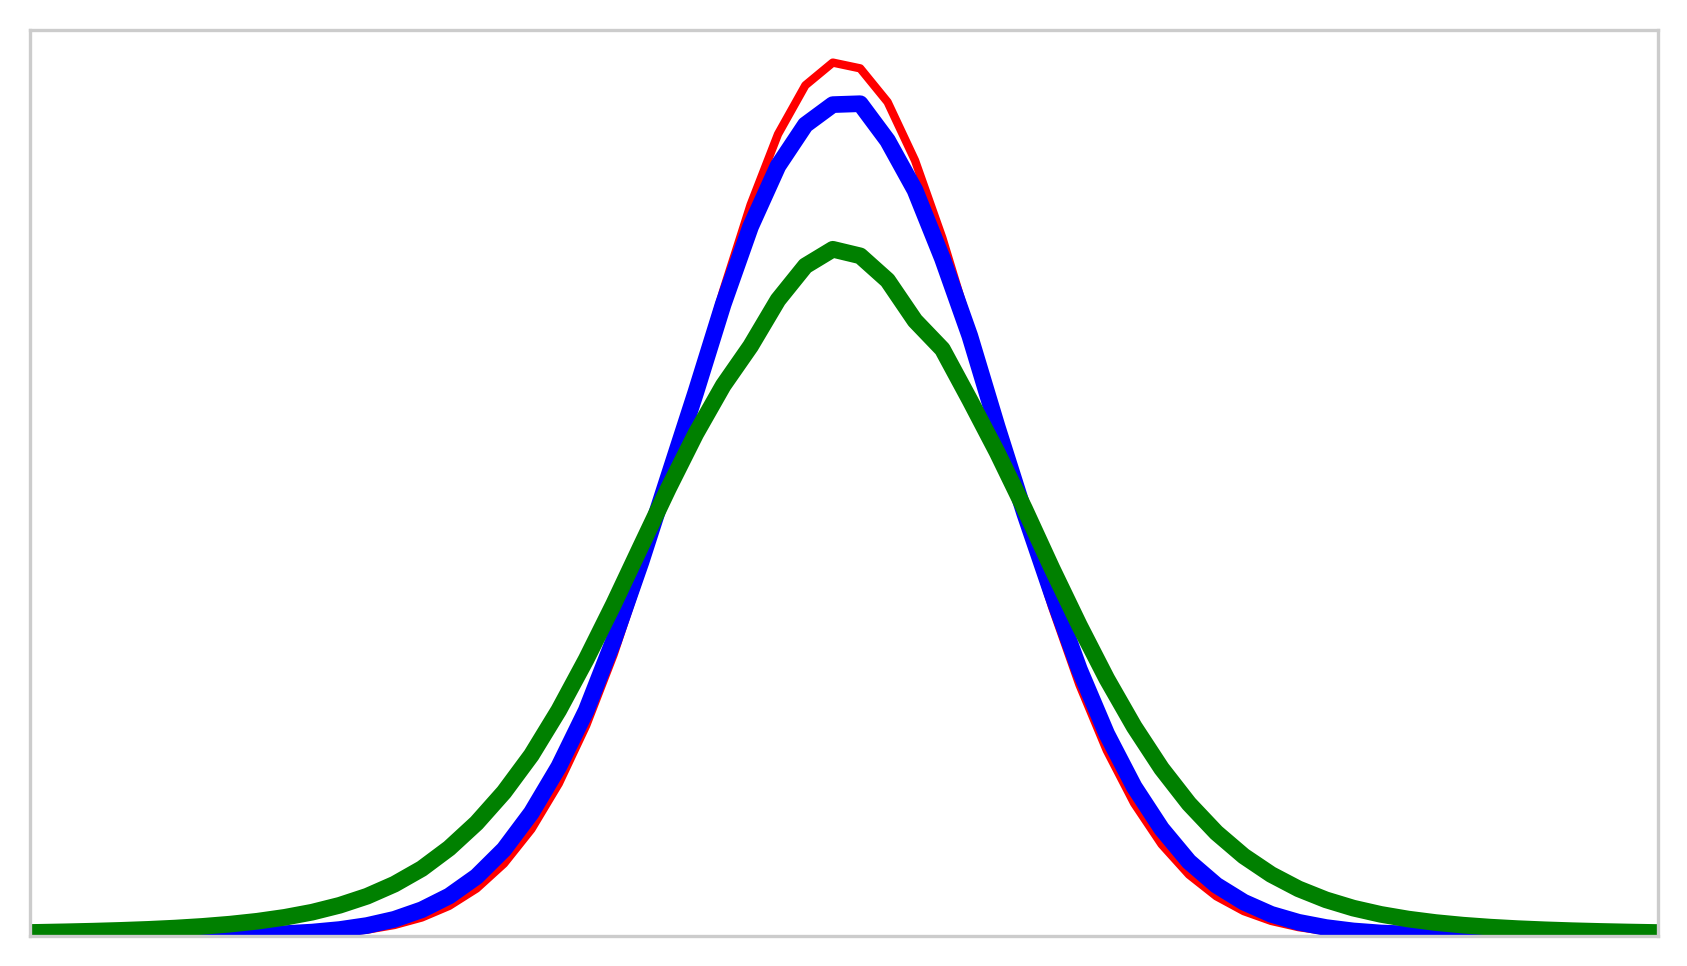

In [621]:
#After 500 seconds
plt.figure(figsize = (7,4), dpi=300)
plt.plot(np.linspace(-10, 10, n), bartrue, linewidth=2, c= 'r', label='True Barycenter')


plt.plot(np.linspace(-10, 10, n), p_history_mir[-48519], linewidth=4, c = 'b',label='Mirror Prox for WB')
plt.plot(np.linspace(-10, 10, n), p_history[-41105], linewidth=4, c = 'g',label='Dual Extrapolation for WB')

#plt.plot(z, bary_wass, linewidth=2, label='IBP with $\gamma =%.3g$'%regIBP, c = 'orange')

plt.ylim(0, 0.075)
plt.xlim(-4, 8)
plt.xticks([])
plt.yticks([])
#plt.legend(loc="upper left", prop={'size': 10.5}, frameon=True)
plt.show()

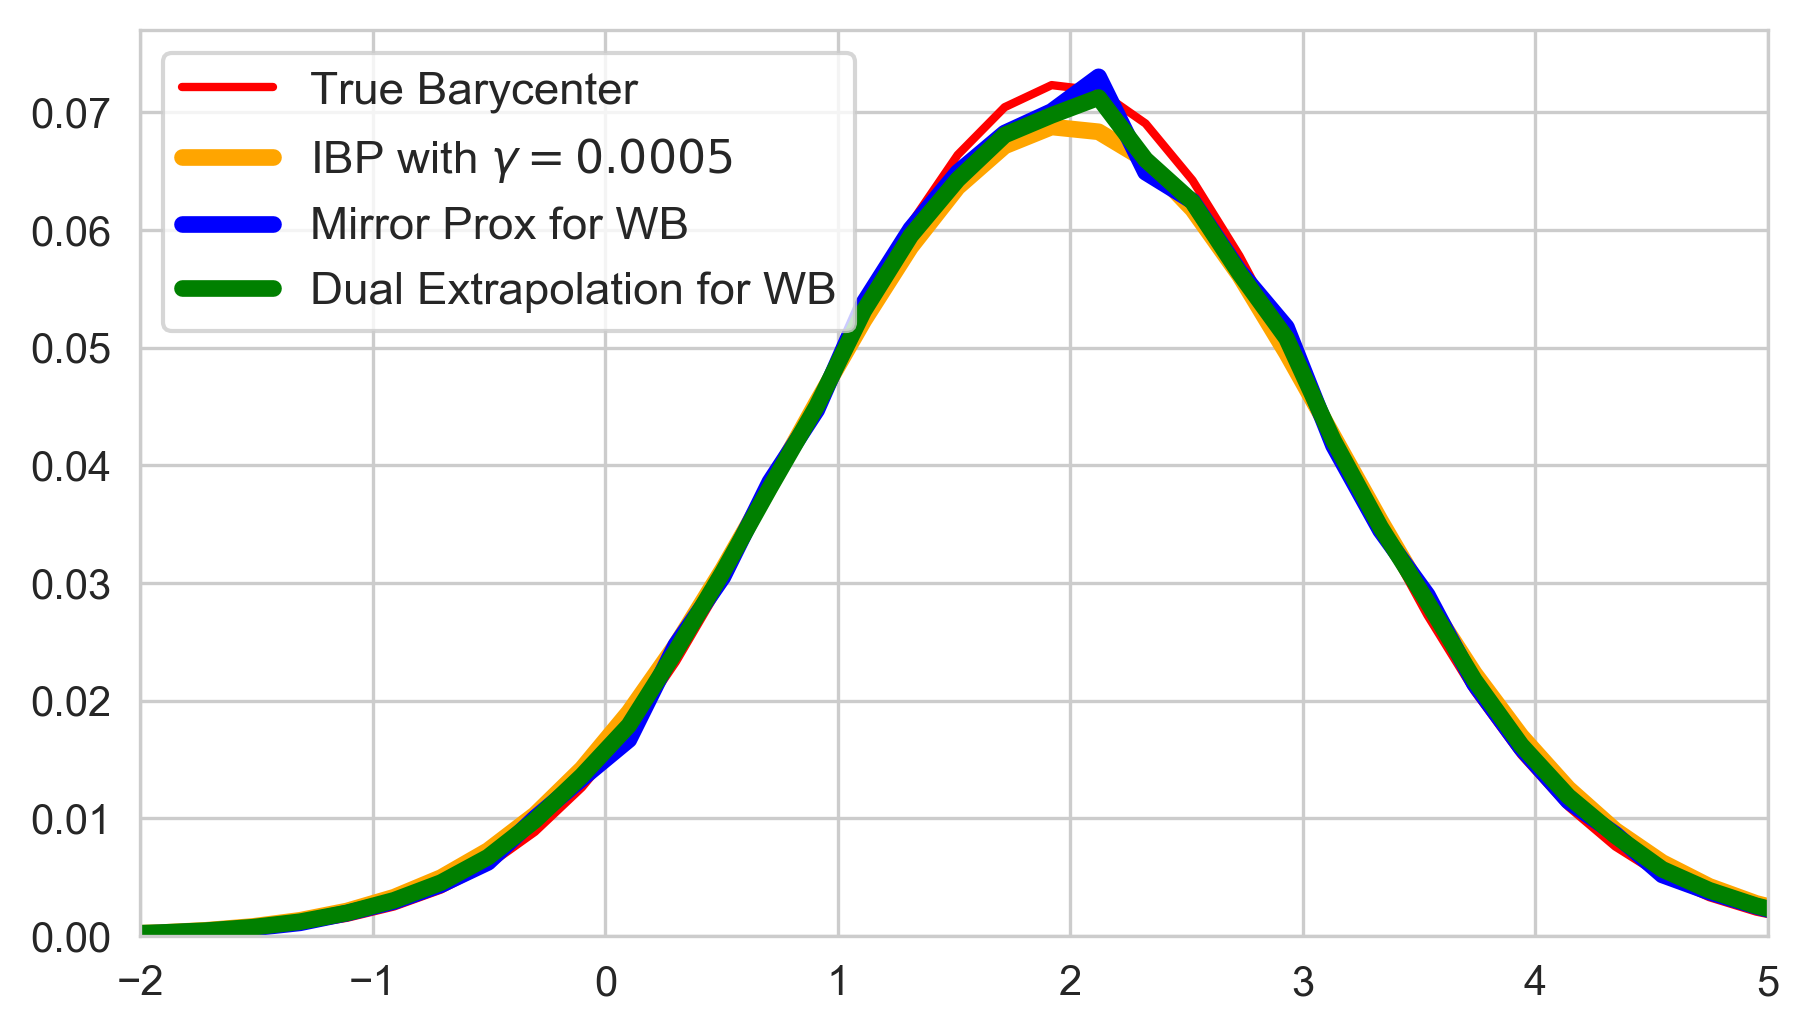

In [642]:

plt.figure(figsize = (7,4), dpi=300)
plt.plot(np.linspace(-10, 10, n), bartrue, linewidth=2, c= 'r', label='True Barycenter')

plt.plot(z, bary_wass, linewidth=4, label='IBP with $\gamma =%.3g$'%regIBP, c = 'orange')


plt.plot(np.linspace(-10, 10, n), p_history_mir[-1], linewidth=4, c = 'b',label='Mirror Prox for WB')
plt.plot(np.linspace(-10, 10, n), p_history[-1], linewidth=4, c = 'g',label='Dual Extrapolation for WB')


plt.ylim(0, 0.077)
plt.xlim(-2, 5)
plt.legend(loc="upper left", prop={'size': 11}, frameon=True)
plt.show()

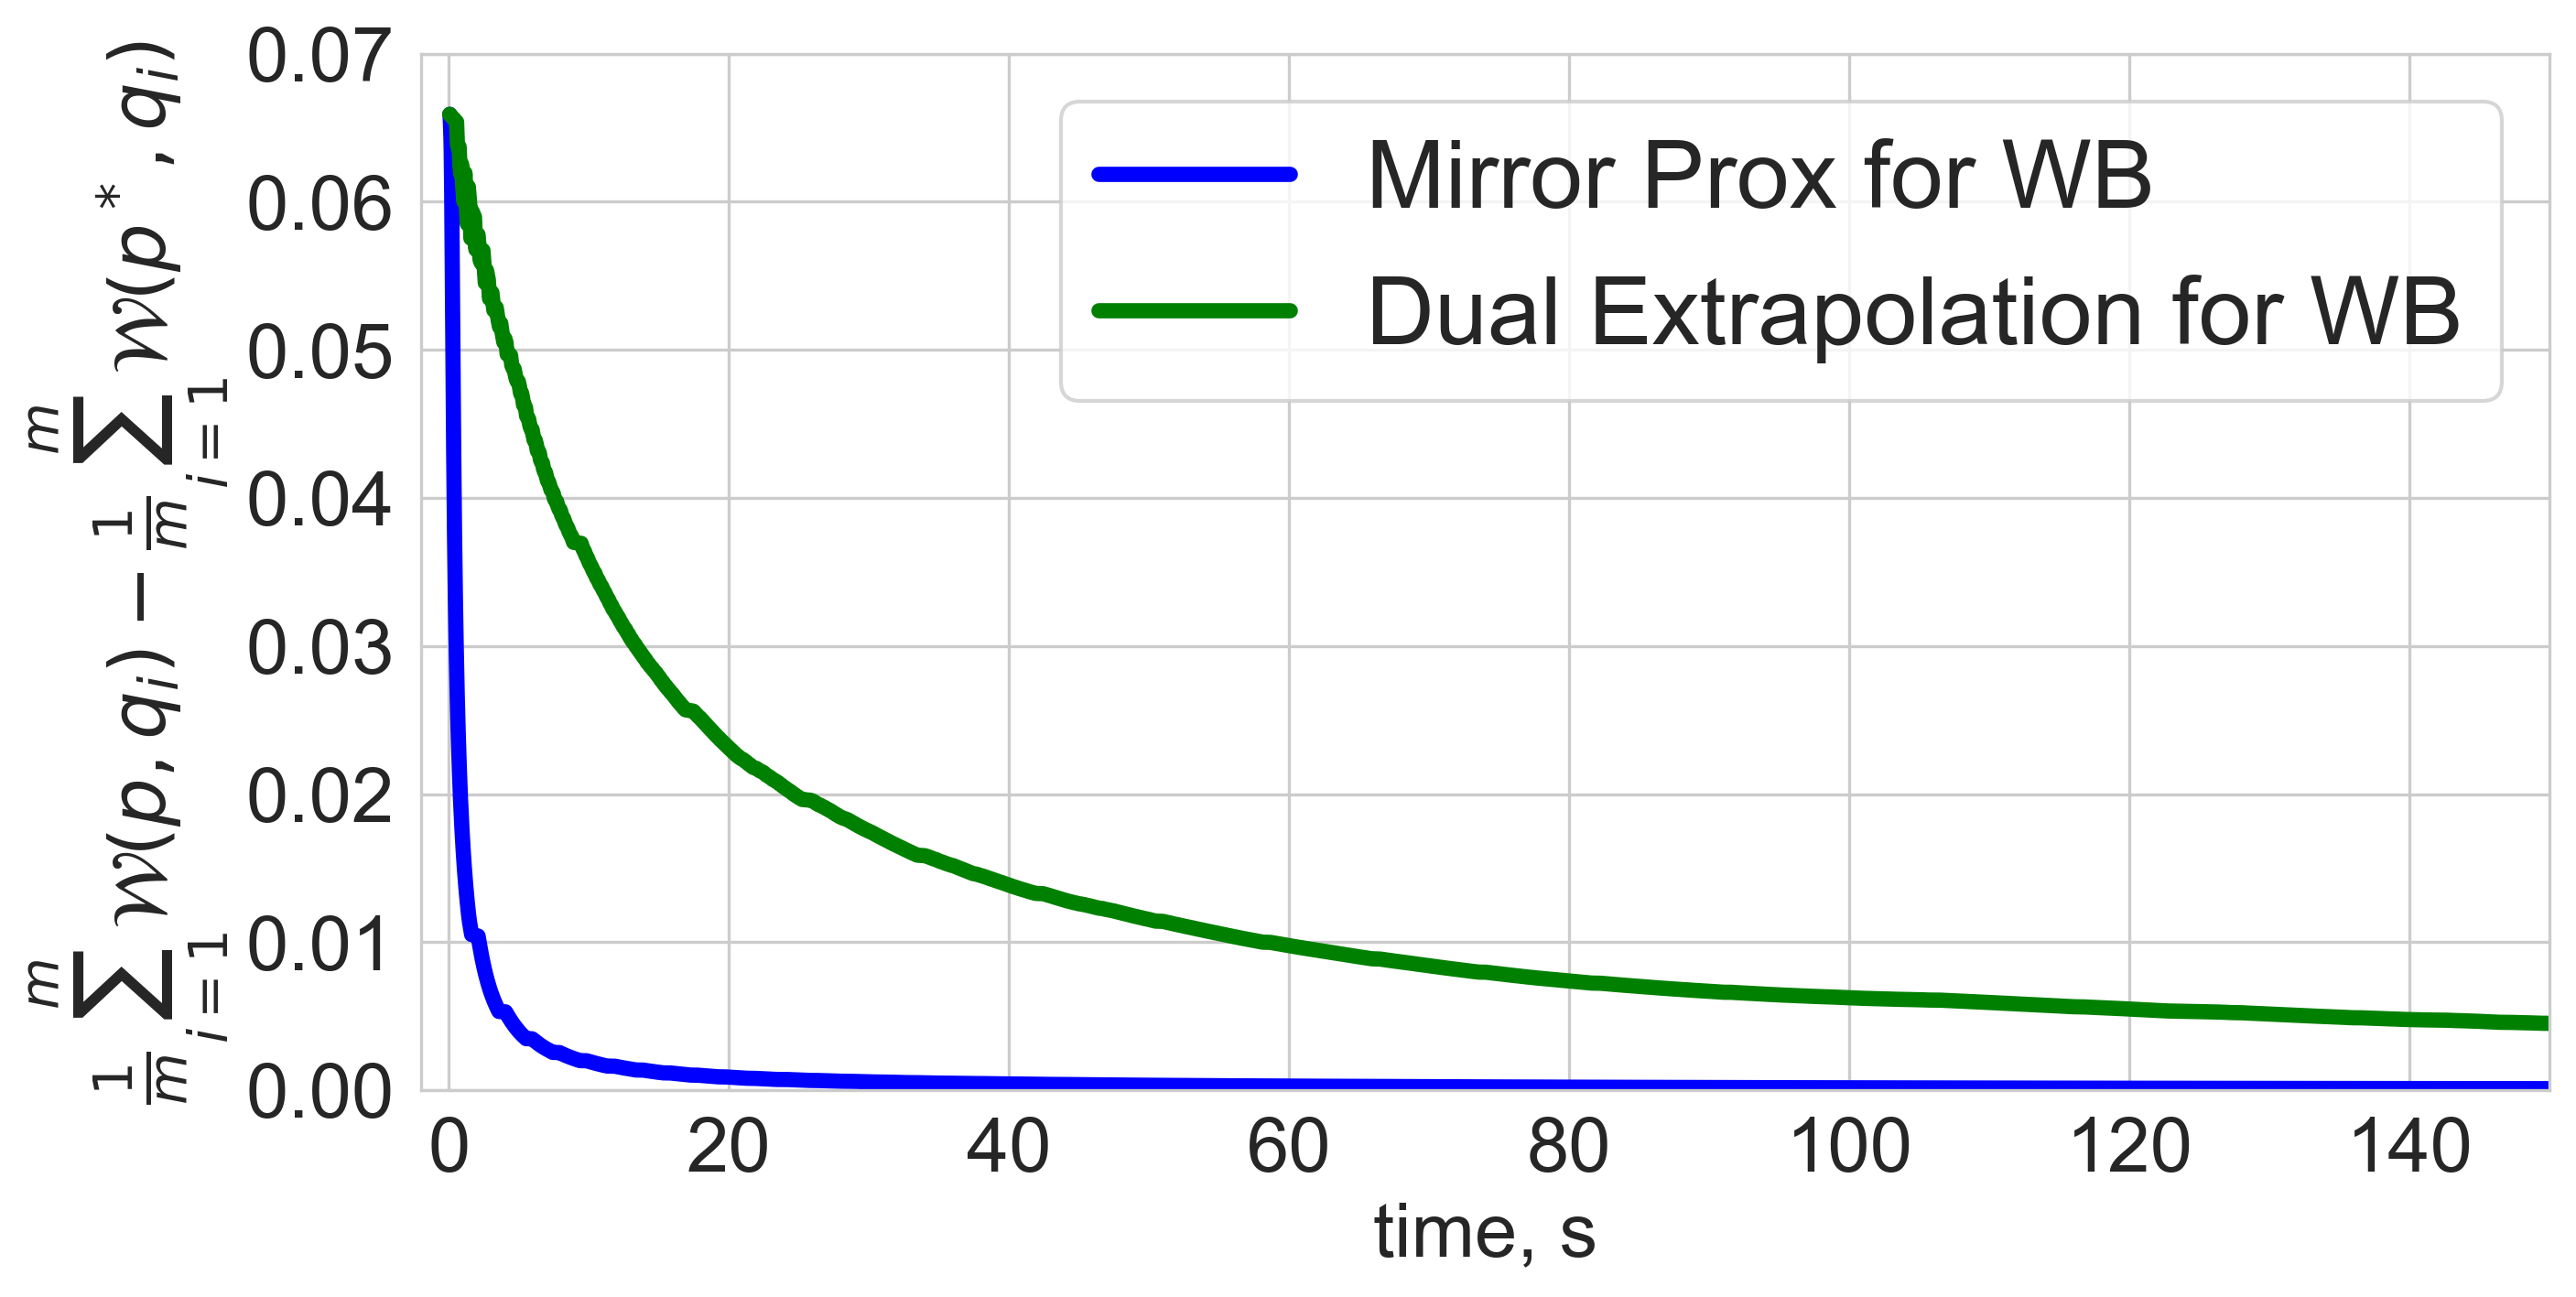

In [315]:
plt.figure(figsize = (10,5), dpi=300)
plt.plot(time_history_mir, loss_history_mir, linewidth=4, c = 'b',label='Mirror Prox for WB')
plt.plot(time_history, loss_history, linewidth=4, c = 'g',label='Dual Extrapolation for WB')

plt.xlabel("time, s", fontsize=20)
plt.ylabel( r'$  \frac{1}{m}\sum_{i=1}^m\mathcal{W}(p,q_i) -\frac{1}{m}\sum_{i=1}^m\mathcal{W}(p^*,q_i) $', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.ylim(0, 0.07)
plt.xlim(-2, 150)
plt.legend(loc="upper right", prop={'size': 25}, frameon=True)
plt.show()

In [322]:
plt.figure(figsize = (10,5), dpi=300)
plt.plot(np.log(time_history_mir), np.log(loss_history_mir), linewidth=4, c = 'b',label='Mirror Prox for WB')
plt.plot(np.log(time_history), np.log(loss_history), linewidth=4, c = 'g',label='Dual Extrapolation for WB')

plt.xlabel("$\log$(time)", fontsize=20)
plt.ylabel( r'$ \log \left( \frac{1}{m}\sum_{i=1}^m\mathcal{W}(p,q_i) -\frac{1}{m}\sum_{i=1}^m\mathcal{W}(p^*,q_i) \right)$', fontsize=16)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlim(-1.6, 5)
plt.legend(loc="lower left", prop={'size': 25}, frameon=True)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


([], <a list of 0 Text yticklabel objects>)

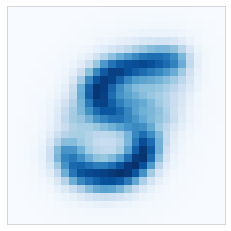

In [15]:
#MIRROR barycenter
phat = mirror(data5[:50],  C,  numItermax=2000)
phat = phat.reshape(img_size,img_size)
plt.imshow(phat, cmap='Blues') 
plt.xticks(())
plt.yticks(())

### IBP Barycenter

([], <a list of 0 Text yticklabel objects>)

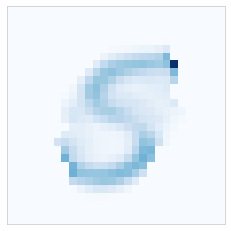

In [62]:
#MNIST 
bar_IBP = np.zeros((2, 28,28))
reg = np.array([ 1e-3, 1e-5])
bar_IBP[0] = ot.bregman.convolutional_barycenter2d(Data5[:50],  reg[0])
bar_IBP[1] = ot.bregman.convolutional_barycenter2d(Data5[:50], reg[1])
plt.imshow(bar_IBP[0],cmap='Blues')
plt.xticks(())
plt.yticks(())

([], <a list of 0 Text yticklabel objects>)

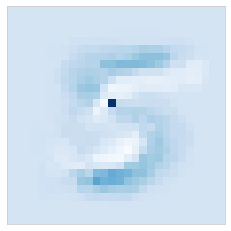

In [64]:
plt.imshow(bar_IBP[1],cmap='Blues')
plt.xticks(())
plt.yticks(())

([], <a list of 0 Text yticklabel objects>)

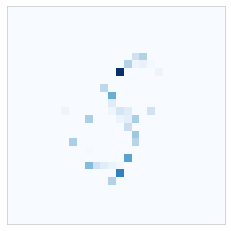

In [7]:
#MNIST 
bar_IBP = ot.bregman.convolutional_barycenter2d(Data5[:50], reg =5e-4, numItermax=100000)
plt.imshow(bar_IBP,cmap='Blues')
plt.xticks(())
plt.yticks(())

### IBP barycenter

([], <a list of 0 Text yticklabel objects>)

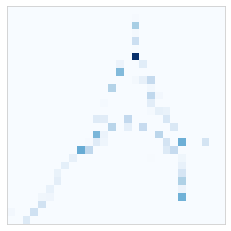

In [110]:
bar_breg = ot.bregman.convolutional_barycenter2d(Adata[:200],  reg=0.001)
plt.imshow(bar_breg, cmap='Blues') 
plt.xticks(())
plt.yticks(())

([], <a list of 0 Text yticklabel objects>)

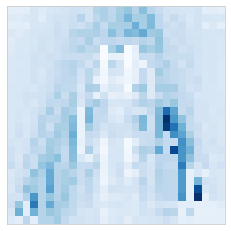

In [107]:
bar_breg = ot.bregman.convolutional_barycenter2d(Adata[:100],  reg=0.00001)
plt.imshow(bar_breg, cmap='Blues') 
plt.xticks(())
plt.yticks(())

### Mirror barycenter

In [11]:
def mirror_ver_font(data,   C,  numItermax=100000, stopThr=1e-9, verbose = True):
    
    d= C.flatten()# vectorized cost matrix
    
    m = data.shape[0] # number of measures
    n = data.shape[1] # img_size**
    #define algorithm constants
    dnorm = LA.norm(d, np.inf)
    eta = 1/(4*dnorm*np.sqrt(3*n*np.log(n)))
    alpha = 2*dnorm*eta*n
    beta =  6*dnorm*eta*np.log(n)
    gamma= 3*eta*m*np.log(n)
    

    #define inputs
    p = np.ones(n) / n
    s = np.copy(p)
    x = np.ones((m, n**2)) / (m*n**2)
    u = np.copy(x)
    y = np.zeros((m, 2*n))
    v = np.copy(y)
    shat = np.zeros_like(p)

    
    #edge-incidence matrix

    A = np.zeros((2*n, n**2))
    i=0
    j=0
    for i in range(n):
        A[i, j:j+n]=1
        j+=n
    t=0
    for i in range(n,2*n):
        for j in range(t, n**2, n):
            A[i,j]=1
        t+=1

    A = csr_matrix(A)

    #Algorithm
    err = 1
    cpt=0
    while (err > stopThr and cpt < numItermax):
        cpt += 1
        
    #for k in range(0, numItermax):

        for i in range (0,m):
            b = np.concatenate((p,data[i]),axis=0)
            v[i] = y[i] + alpha * (A.dot(x[i]) - b) # variable for y
           
            flag = np.abs(v[i]) >1
            v[i, flag] = np.sign(v[i, flag])

            u[i] =  x[i]*np.exp(-gamma * (d + 2*dnorm * A.transpose().dot(y[i]))) / np.sum( x[i]*np.exp(-gamma * (d + 2*dnorm * A.transpose().dot(y[i]))) )  # variable for x
            
        s = p*np.exp(beta*np.sum(y[:,:n],0)) / np.sum( p*np.exp(beta*np.sum(y[:,:n],0)) )  # variable for p
        pold = np.copy(shat)
        shat +=s       
        for i in range (0,m):
            b = np.concatenate((s,data[i]),axis=0)
            y[i] = y[i] + alpha * (A.dot(u[i]) - b) 

            flag = np.abs(y[i]) >1
            y[i, flag] = np.sign(y[i, flag])

            x[i] = x[i]*np.exp(-gamma * (d + 2*dnorm * A.transpose().dot(v[i]))) / np.sum( x[i]*np.exp(-gamma * (d + 2*dnorm * A.transpose().dot(v[i]))) ) 
       
        p = p*np.exp(beta*np.sum(v[:,:n],0)) / np.sum( p*np.exp(beta*np.sum(v[:,:n], 0)) )  
        
        if i % 10 == 1:
            err = np.sum(np.abs(pold - shat/cpt))
            
        phat = shat / cpt
        
        if verbose and cpt % 10 == 0: 
        #                       # Visualize
            display.clear_output(wait=True)
            # plt.figure(figsize=(6, 4), dpi=300)
            plt.imshow(phat.reshape(28,28), cmap='Greens') 
            plt.xticks(())
            plt.yticks(()) 
            plt.show()
            print('Pass {} iterations'.format(cpt), flush=True)
        if verbose and cpt % 100 == 0:
            
            with open('WBimages/fonts_distr/iter{}.npy'.format(cpt), 'wb') as f:
                np.save(f, phat)
    #Output   

    return phat

([], <a list of 0 Text yticklabel objects>)

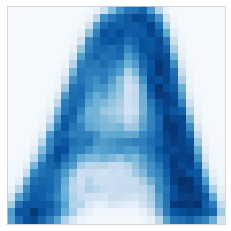

In [362]:
bar_mirr_font = mirror_ver_font(AAdata[:100], C,   numItermax=4000)
bar_mirr_font = bar_mirr_font.reshape(img_size,img_size)
plt.imshow(bar_mirr_font, cmap='Blues') 
plt.xticks(())
plt.yticks(())
